In [374]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Lab: Logistic Regression, LDA, QDA, and KNN

#### The Stock Market Data

In [375]:
# Load dataset
Smarket = load_data('Smarket')
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [376]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [377]:
# Compute correlation matrix
Smarket.select_dtypes(include=[np.number]).corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: >

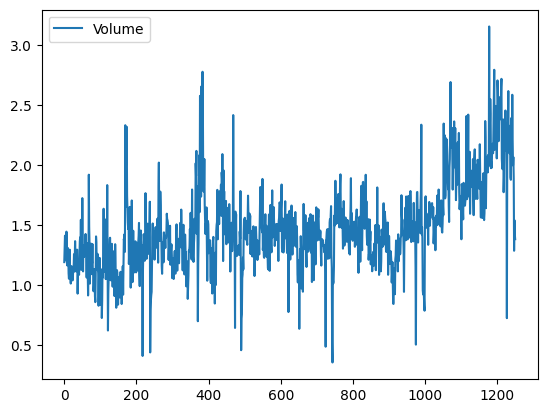

In [378]:
Smarket.plot(y='Volume')

#### Logistic Regression

In [379]:
# Fit a logistic regression model in order to predict Direction using Lag1 through Lag5 and Volume

allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [380]:
# Extracts coefficients for the fitted model
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [381]:
# Extracts p-values for the coefficients
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [382]:
# To predict the probability that the market will go up, given values of the predictors
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [383]:
# To make a prediction as to whether the market will go up or down on a particular day
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"
labels[:10]

array(['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down'],
      dtype='<U4')

In [384]:
# Confusion matrix
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [385]:
# to compute the fraction of days for which the prediction was correct
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [386]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [387]:
# Fit logistic regression model on training dataset
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [388]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [389]:
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [390]:
# Test accuracy and error rate
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [391]:
# Fit the logistic regression using just Lag1 and Lag2
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [392]:
# Evaluate overall accuracy & accuracy within the days when LR predicts an increase
(35+106)/252,106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [393]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5], 
                        'Lag2':[1.1, -0.8]})
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

#### Linear Discriminant Analysis

In [394]:
# Fit the model using only the observations before 2005
lda = LDA(store_covariance=True)

In [395]:
X_train, X_test = [M.drop(columns=['intercept'])
for M in [X_train, X_test]]
lda.fit(X_train, L_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


In [396]:
# Compute means
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [397]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [398]:
# Compute priors
lda.priors_

array([0.49198397, 0.50801603])

In [399]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [400]:
# Checks if the LDA probability-based predictions exactly match the LDA class predictions
lda_prob = lda.predict_proba(X_test)
np.all(np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred)

True

In [401]:
# Checks whether the class with the highest predicted probability from LDA matches the predicted classes
np.all([lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred)

True

In [402]:
# Counts samples with LDA class 0 probability > 0.9
np.sum(lda_prob[:,0] > 0.9)

0

####  Quadratic Discriminant Analysis

In [403]:
# Fit a QDA model
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [404]:
# Compute means and priors
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [405]:
# Estimate the covariance of the first class
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [406]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [407]:
# Prediction accuaracy
np.mean(qda_pred == L_test)

0.5992063492063492

#### Naive Bayes

In [408]:
# Fit a naive Bayes model
NB = GaussianNB()
NB.fit(X_train, L_train)

,priors,None
,var_smoothing,1e-09


In [409]:
NB.classes_, NB.class_prior_, NB.theta_,  NB.var_

(array(['Down', 'Up'], dtype='<U4'),
 array([0.49198397, 0.50801603]),
 array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([[1.50355429, 1.53246749],
        [1.51401364, 1.48732877]]))

In [410]:
# Verify the mean computation
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [411]:
# Verify the variance
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [412]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [413]:
# Predicted probabilities for the first 5 test samples
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

####  K-Nearest Neighbors

In [414]:
# Perform KNN for k=1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [415]:
# Calculates the accuracy of K=1 KNN model
(83+43)/252, np.mean(knn1_pred == L_test)

(0.5, 0.5)

In [416]:
# Perform KNN for k=3
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

In [417]:
# Switch to carava df for KNN
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [418]:
# Define the features
feature_df = Caravan.drop(columns=['Purchase'])

In [419]:
# Standardize the data
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

feature_std = pd.DataFrame(X_std,
                           columns=feature_df.columns)
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [420]:
# Split the observations for train & test
(X_train, X_test, y_train, y_test) = train_test_split(feature_std, Purchase, test_size=1000, random_state=0)

In [421]:
# Perform KNN for k=1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

In [422]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [423]:
# Calculates the proportion of correct positive predictions
9/(53+9)

0.14516129032258066

In [424]:
# Tuning Parameters
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' + 
             ' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(K, pred, did_rent, did_rent / pred))

K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%


In [425]:
# Comparison to Logistic Regression
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


In [426]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [427]:
# Calculates the proportion of correct positive predictions
9/(20+9)

0.3103448275862069

#### Linear and Poisson Regression on the Bikeshare Data

In [428]:
# Load data
Bike = load_data('Bikeshare')
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [429]:
# Linear Regression
X = MS(['mnth', 'hr', 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
# summarize(M_lm)

In [430]:
# Convert categorical to numeric
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [431]:
# Refitting
X2 = MS([mnth_encode, hr_encode, 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
# S2

In [432]:
# Extract all the coefficients for month from the coefficients of M2_lm
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [433]:
# Append Dec as the negative of the sum of all other months.
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month, pd.Series([-coef_month.sum()], index=['mnth[Dec]'])])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

Text(0, 0.5, 'Coefficient')

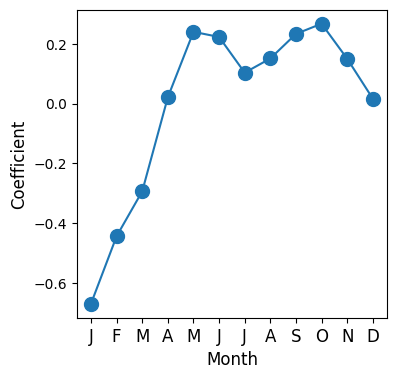

In [444]:
# Month plot
fig_month, ax_month = subplots(figsize=(4,4))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize =12)
ax_month.set_xlabel('Month', fontsize=12)
ax_month.set_ylabel('Coefficient', fontsize=12)

Text(0, 0.5, 'Coefficient')

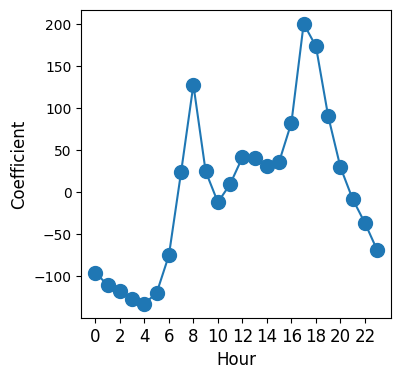

In [443]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])])

# Hour plot
fig_hr, ax_hr = subplots(figsize=(4,4))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=12)
ax_hr.set_xlabel('Hour', fontsize=12)
ax_hr.set_ylabel('Coefficient', fontsize=12)

#### Poisson Regression

In [436]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [437]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month, pd.Series([-coef_month.sum()], index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])])

Text(0, 0.5, 'Coefficient')

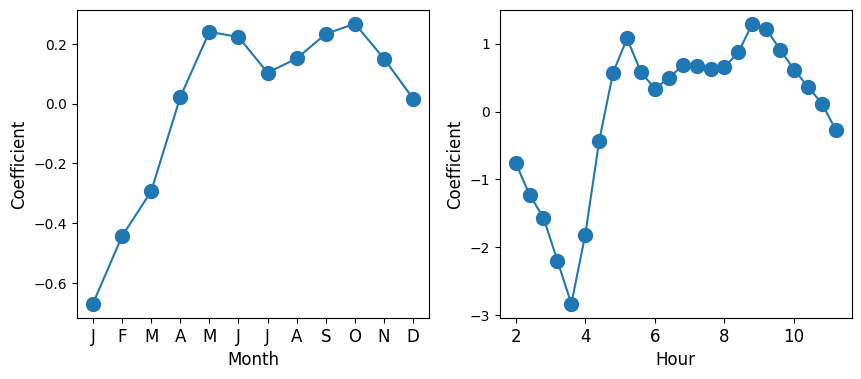

In [442]:
fig_pois, (ax_month, ax_hr) = subplots(1, 2, figsize=(10,4))
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=12)
ax_month.set_xlabel('Month', fontsize=12)
ax_month.set_ylabel('Coefficient', fontsize=12)
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize=12)
ax_hr.set_xlabel('Hour', fontsize=12)
ax_hr.set_ylabel('Coefficient', fontsize=12)

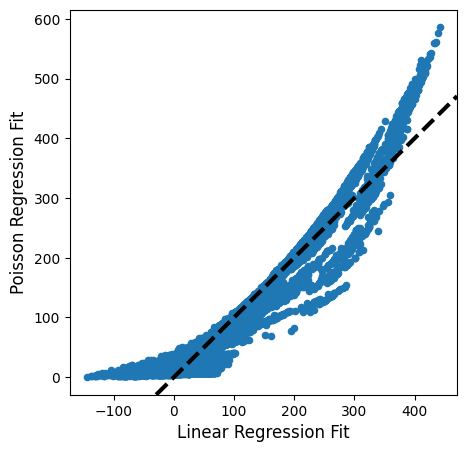

In [440]:
fig, ax = subplots(figsize=(5,5))
ax.scatter(M2_lm.fittedvalues ,
M_pois.fittedvalues, s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=12)
ax.set_ylabel('Poisson Regression Fit', fontsize=12)
ax.axline([0,0], c='black', linewidth=3,
linestyle='--', slope=1)